In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd , eig, inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor

In [2]:
#files on disk
scores_file = 'full_dataset.csv'
vector_file_i = 'X_i_doc2vec.npy'
vector_file_i_10 = 'X_i_doc2vec_10.npy'

#load files
df = pd.read_csv(scores_file, index_col=0)

X_i = np.load(vector_file_i)
X_i_10 = np.load(vector_file_i_10)

y = df['PHQ8_Binary'].values
y2 = df['PHQ8_Score'].values

In [3]:
print(y.shape)
print(X_i.shape)
print(X_i_10.shape)

(189,)
(189, 100)
(189, 10)


In [25]:
#let's create a copy of the raw scores
y_bins = df['PHQ8_Score'].copy(deep=True)

#start binning
y_bins[y_bins <= 4] = 0
y_bins[np.logical_and(y_bins > 4, y_bins < 10)] = 5
y_bins[np.logical_and(y_bins > 10, y_bins < 15)] = 10
y_bins[np.logical_and(y_bins > 15, y_bins <= 25)] = 15
#y_bins[y_bins >= 20] = 20

### EDA

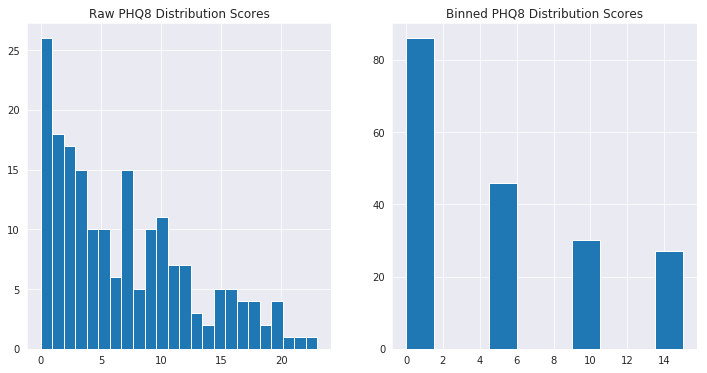

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(df['PHQ8_Score'], bins=24)
ax[0].set_title('Raw PHQ8 Distribution Scores')

ax[1].hist(y_bins)
ax[1].set_title('Binned PHQ8 Distribution Scores')

plt.show()

### Training, Binned Regression

Null Hypothesis, H0: there is no difference in the word embeddings created using the transcripts of those who report high feelings of depression and those that don't

Alternative Hypothesis, H1: There is a difference.

In [27]:
"""
regress_and_report() creates lists for root mean squared error and r2 score.
Given a sklearn model, the X and y data sets, it creates stratified k-fold training and test sets.
The model is trained, and then metrics are reported and all lists are returned for further analysis.
"""
def regress_and_report(model, X, y, num):
    
    #for reporting metrics
    mse, r2 = [], []

    #for confusion matrix
    predictions = []
    ytest = []

    #create splits here
    skf = StratifiedKFold(n_splits=num)
    skf.get_n_splits(X, y)

    #loop over n splits
    for train_idx, test_idx in skf.split(X, y):
        #get subsets of data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
    
        ytest.append(y_test)
    
        #fit and predict on training and test data
        preds = model.fit(X_train, y_train).predict(X_test)
        predictions.append(preds)
    
        #calculate scores and append to lists
        mse_ = mean_squared_error(y_test, preds)
        mse.append(mse_)
    
        r2_ = r2_score(y_test, preds)
        r2.append(r2_)
        
    
    rmse = np.sqrt(mse)
    
    report_metrics_regress(rmse, r2)
        
    return rmse, r2, ytest, predictions

In [28]:
"""
This helper method takes in lists of root mean squared error and r2 score
It then outputs the mean score for each list.
"""
def report_metrics_regress(rmse, r2):
    #calculate means of scores for reporting
    mean_rmse = np.round(np.mean(rmse), 4)
    mean_r2 = np.round(np.mean(r2), 4)
    
    print('Mean rmse score: ', mean_rmse)
    print('Mean r2 score: ', mean_r2)

In [29]:
"""
Plot root mean squared error and r2 score score across k-splits to see how they vary.
"""
def plot_metrics_regress(rmse):
    plt.plot(rmse, label='rmse', color='r')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('How Regression Metrics Vary Across Stratified Splits')
    
    plt.xlabel('Split Number K')
    plt.ylabel('Root Mean Squared Error')

    plt.show()

In [30]:
#define regression models
num = 10

lr = LinearRegression()
sgd = SGDRegressor(max_iter=100, tol=1e-3)
forest = RandomForestRegressor(n_estimators=10)
ridge = Ridge()

In [31]:
rmse, r2, ytest, preds = regress_and_report(ridge, X_i, y_bins, num)

Mean rmse score:  5.4007
Mean r2 score:  0.0101


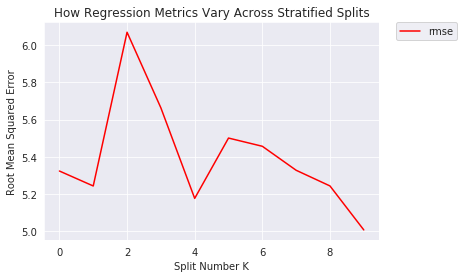

In [32]:
plot_metrics_regress(rmse)

#plt.savefig('metrics_regression_ridge.pdf', format='pdf', bbox_inches='tight')

In [33]:
print(ytest[-2], '\n')
print(preds[-2])

109    10
110    10
115    10
150    15
155     5
156    15
158     5
162     5
167     0
168     0
169     0
170     0
171     5
172     0
173     0
174     0
176     0
Name: PHQ8_Score, dtype: int64 

[3.6187782 5.078417  4.0744333 4.369213  5.048277  4.1560106 6.0424747
 6.7343187 3.48639   4.245633  3.6939483 3.5265949 3.8907814 3.9468882
 3.9652941 5.1441965 4.1530085]


An analysis where we bin groups of peole together is movtivated by the fact that we have so few samples of people who report high rates of depression. This is a major flaw in this dataset.

Even if we binned groups of people together, MSE stays greater than 5. And you can see that in the above cell, the model is predicting values between 3 adn 6 each time.